# Midterm Project

## Submission
The project is due on ***March 28 2022, 23:59 CET***. The time stamp of the email or upload determines the submission time. *Late submissions will NOT be considered, and graded as 0.*

Submitting the midterm means you will be counted as attending student, meaning the final project is a group project. You can **not** switch status after the midterm deadline.

To submit, please:

1. rename this file with your student ID
2. copy this file and all additional data into a folder with your student ID
3. zip the entire folder
4. send a copy of the zip file to Amanda Cercas Curry <amanda.cercas@unibocconi.it>

For large files, you can use **wetransfer**. Please do not use Dropbox links, since they are not time-stamped!

# 1. Data and Preprocessing

## Descritpion of the dataset
The following project will focus on the analysis of data from the EU LIFE programme. The LIFE programme is the EU's instrument for the funding of projects in the field of climate and environmental action. I have scraped data from the EU LIFE project repository, containing details on the 5000+ projects that this programme has funded throughout its 29 years of activity. 

The whole data scraping and assembly procedure can be found in the notebook labelled: **Web_scraping_and_dataset_assembly.ipynb**

The dataset contains the below columns:
 1. project_title: official title of the project (type: str)
 2. description: description of the background and objectives of the project (type: str)
 3. start_year: year in which the project started operating (type: int)
 4. end_year: actual or expected (if the project is still ongoing) year of finish for the project (type: int)
 5. bidget_€: Total budget required by the project in euros (type: int)
 6. EU_contributio_€: Total contibution to the overall budget the EU has made in euros (type: int)
 7. cordinator_location: Country of the institution that is incharge of enacting the project (type: str)

Example of a project's page from the EU LIFE repository: https://webgate.ec.europa.eu/life/publicWebsite/project/details/1

Link to full database: https://webgate.ec.europa.eu/life/publicWebsite/search

In [2]:
#Importing libraries and data
import spacy
import pandas as pd
from string import punctuation
from collections import defaultdict

####Install this to have progress bars under for loops run####
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
nlp = spacy.load('en_core_web_sm')
df = pd.read_csv('EU_LIFE_projects.csv')
df.head()

,project_title,description,start_year,end_year,budget_€,EU_contribution_€,cordinator_location
0,European Network of Natura 2000; management p...,The Hainich zone covers 20 000 ha of a mainly ...,1995,1998,1151200,575600,Germany
1,Exemplary preservation and development of floo...,"In the central European context, the lower rea...",1996,1999,397600,198800,Germany
2,Demonstration of the Preparation an Implementa...,The Wadden Sea is an intertidal area at the so...,1995,1998,1370400,685200,Germany
3,Evaluation of the Conservation Status of Natur...,The implementation of the Habitats Directive (...,1996,1998,913600,456800,Germany
4,Protecting flying squirrel habitats in the Nuu...,"Nuuksio National Park was established in 1994,...",1995,1998,919400,459700,Finland


In [5]:
#Before preprocessing: Extracting each single word before preprocessing(I use spacy also here to find individual tokens so
#that I have a fairer comparison once I extracts tokens again with spacy after prerocessing)
words = defaultdict(lambda: 0)
dc = []
for doc in tqdm(df['description'].tolist()):
    d = []
    for token in nlp(doc):
        d.append(token.text)
        words[token.text] +=1
    dc.append(d)
    

100%|██████████| 5015/5015 [14:08<00:00,  5.91it/s] 



Summary Statistics (BEFORE PREPROCESSING):

Number of documents: 5015
Average words per document: 1226.71
Number of types: 62522
Number of tokens: 6151950
Top 5 most used words: ['the', 'of', ',', 'and', '.']



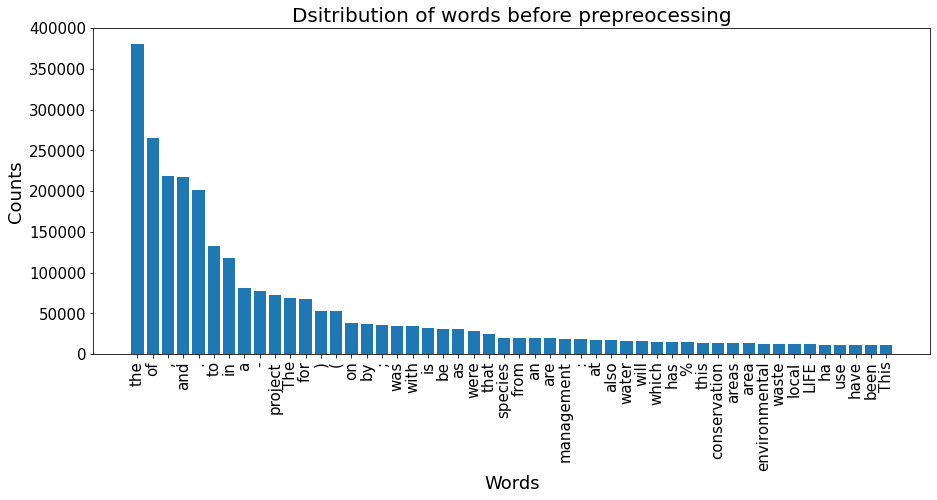

In [6]:
#Statistics before preprocessing:
sort_list_words = [k for k, v in sorted(words.items(), key=lambda item: item[1], reverse = True)]
sort_counts = [v for k, v in sorted(words.items(), key=lambda item: item[1], reverse = True)]
n_docs = df.shape[0]
avg_wordsperdoc = sum([len(i) for i in dc])/df.shape[0]
n_types = len(words.keys())
n_tokens = sum(words.values())
top5_w = sort_list_words[:5]
print(f'''
Summary Statistics (BEFORE PREPROCESSING):

Number of documents: {n_docs}
Average words per document: {round(avg_wordsperdoc, 3)}
Number of types: {n_types}
Number of tokens: {n_tokens}
Top 5 most used words: {top5_w}
''')

#Plotting the distribution (only first 50 words shown for readibility)
params = {
   'axes.labelsize': 18,
   'font.size': 16,
   'legend.fontsize': 11,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
    'axes.titlesize': 20,
   'figure.figsize': [15, 6]
   } 
plt.rcParams.update(params)
plt.bar(sort_list_words[:50], sort_counts[:50])
plt.xticks(rotation = 90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Dsitribution of words before prepreocessing')
plt.show()

In [8]:
#Preprocesing
clean_nolemma = [] # set of clean data without lemmatization
clean_lemma = [] #set of clean data with lemmatization

for i in tqdm(df['description'].tolist()):
    nop = re.sub('[\W]', ' ', i) #Removing punctuations
    t = re.sub('[\d]', ' ',nop )#removing digits
    cl = re.sub('[\s\s]+', ' ', t) #re-formatting extra whitespaces
    lower = cl.lower() #turning everything in to lowercase
    nolemma = []
    lemma  = []
    for token in nlp(lower):
        #Filtering stop words and non content words
        if token.pos_ in {'NOUN', 'VERB', 'PROPN', 'ADJ', 'ADV'} and not token.is_stop:
            nolemma.append(token.text)# extracting the text
            lemma.append(token.lemma_)# extracting the lemmas
    clean_nolemma.append(nolemma)
    clean_lemma.append(lemma)

100%|██████████| 5015/5015 [11:53<00:00,  7.03it/s] 


In [9]:
#Assigning the cleaned columns to the dataframe for ease of use later on in analysis
df['clean_text'] = clean_nolemma
df['clean_lemma'] = clean_lemma

In [10]:
#Dictionaries for word counts
text = dict()
lemma = dict()


for i in tqdm(clean_nolemma):
    for word in i:
        if word not in text:
            text[word] = 1
        else:
            text[word] += 1

for i in tqdm(clean_lemma):
    for word in i:
        if word not in lemma:
            lemma[word] = 1
        else:
            lemma[word] += 1

100%|██████████| 5015/5015 [00:00<00:00, 5569.83it/s]



Summary Statistics (AFTER PREPROCESSING):

Number of documents: 5015
Average words per document: 595.505
Number of tokens: 2986457

NO Lemmatization:
Number of types: 44554
Top 5 most used words: ['project', 'species', 'management', 'water', 'life']

Lemmatization:
Number of types: 38593
Top 5 most used words: ['project', 'area', 'habitat', 'management', 'specie']



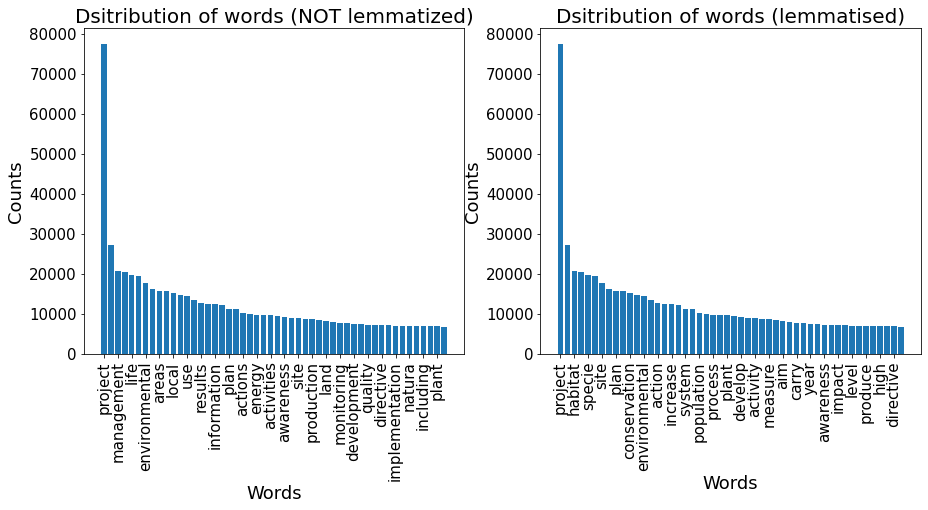

In [11]:
#Statistics after preprocessing:
sort_text_words = [k for k, v in sorted(text.items(), key=lambda item: item[1], reverse = True)]
sort_text_counts = [v for k, v in sorted(text.items(), key=lambda item: item[1], reverse = True)]
avg_wordstext = sum([len(i) for i in clean_nolemma])/df.shape[0]
no_types = len(text.keys())
no_tokens = sum(text.values())
top5_wno = sort_text_words[:5]

sort_lemma_words = [k for k, v in sorted(lemma.items(), key=lambda item: item[1], reverse = True)]
sort_lemma_counts = [v for k, v in sorted(lemma.items(), key=lambda item: item[1], reverse = True)]
lem_types = len(lemma.keys())
lem_tokens = sum(lemma.values())
top5_wlem = sort_lemma_words[:5]

print(f'''
Summary Statistics (AFTER PREPROCESSING):

Number of documents: {n_docs}
Average words per document: {round(avg_wordstext, 3)}
Number of tokens: {no_tokens}

NO Lemmatization:
Number of types: {no_types}
Top 5 most used words: {top5_wno}

Lemmatization:
Number of types: {lem_types}
Top 5 most used words: {top5_wlem}
''')

#Plotting the distribution (only first 50 words shown for readibility)

params = {
   'axes.labelsize': 18,
   'font.size': 16,
   'legend.fontsize': 11,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
    'axes.titlesize': 20,
   'figure.figsize': [25, 9]
   } 

fig, ax = plt.subplots(1, 2)
plt.rcParams.update(params)
ax[0].bar(sort_text_words[:50], sort_lemma_counts[:50])
ax[0].set_xticks(sort_text_words[:50:2])
ax[0].set_xticklabels(sort_text_words[:50:2],rotation = 90)
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Counts')
ax[0].set_title('Dsitribution of words (NOT lemmatized)')

#ax[1].rcParams.update(params)
ax[1].bar(sort_lemma_words[:50], sort_lemma_counts[:50])
ax[1].set_xticks(sort_lemma_words[:50:2])
ax[1].set_xticklabels(sort_lemma_words[:50:2],rotation = 90)
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Counts')
ax[1].set_title('Dsitribution of words (lemmatised)')


plt.show()

As part of the preprocessing step I have removed:

-> numbers: By manually examining samples of the project descriptions it is possible to notice how numbers that are utilised in these texts often refer to quantities related to land size, ID numbers for documents and population sizes. For the nature of the analyses that will be carried out, this is infromation is information not essential and can thus be removed.

-> stop words, closed class words and punctuation: These help to structure the grammatical form of a sentence and do not hold great semantic value themselves.

Overall, this allows to maintain focus solely on the class of content words where most of the semantic meaning will reside. Indeed, the semantic meaning is a key aspect related to the analysis questions highlighted in the next section. I thus also extract lemmas to further reduce the variability of my corpus and emphasise the underlying semantic meaning.
I have also decided to keep a set of tokens without lemmatization as these will be important to preserve differences in the morphology, and thus the underlying syntactical relationships between words, which will be of value for a part of the analysis.

Indeed, it is visible from the counts of types before and after preprocessing that the chosen procedures have successfully cut variability, reducing types number from 62522 before preprocessinng to 44554 (without lemmatization) and 38593 (with lemmatization).

In [12]:
#Uncomment to access cleaned data without re-running the whole preprocessing
#df = pd.read_pickle('data_with_preprocessing.pkl')

# 2. Analysis and Visualisation

## Project Overview
The overarching aim of this project is to gather a better understanding of how the EU is supporting the efforts to protect the environment. Specifically, this analysis sets iteslf the goal to understand the topical areas in which the EU is active in funding projects that protect nature, how the patterns of funding have evolved thoughout the time in which these type of investments have been active and how these contributions differ across varios parts of the world. The analysis thus evolves in different key sub-sections, each addressing questions aimed at fulfilling the above mentioned final goal of the analysis.

## Sub-section 1: What do projects generally talk about and how is the terminology related across the whole corpus ?



### Word2Vec representation

In [13]:
#Representing twords in the coropus as vectors using Word2Vec
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION

np.random.seed(5)

corpus = df.clean_lemma.tolist()

# initialize model
w2v_model = Word2Vec(vector_size = 303,
                     window = 10, # window for sampling
                     sample=0.0001, # subsampling rate
                     epochs=200, # iterations
                     negative=5, # negative samples
                     min_count=100, # minimum threshold
                     workers=-1, # parallelize to all cores
                     hs=1 # no hierarchical softmax
)

# build the vocabulary
w2v_model.build_vocab(corpus)

# train the model
w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)



(0, 0)

Here the word2vec representation was manually tuned, trying different values of vector_size, window size and method used for training (in this case hierarchical softmax worked best) to increase the similarity of words like 'waste' and 'energy' to 'managment' compared to 'business', which in this context is assumed to be further away. In addition, we can also see that the word 'bad' has a negative similarity, thus is even further away (polar opposite) to conservation. Indeed, we would expect the latter's context to be largely composed of words with a positive connotation due to the nature of the corpus.

In [14]:
print(w2v_model.wv.similarity('waste', 'management'))
print(w2v_model.wv.similarity('energy', 'management'))
print(w2v_model.wv.similarity('business', 'management'))
print(w2v_model.wv.similarity('conservation', 'bad'))

0.08890206
0.13912441
0.07949935
-0.088703394


In [15]:
#Extracting the matrix of word embeddings
wvec = w2v_model.wv.vectors

### t-SNE

In [16]:
#Dimensionality reduction with TSNE to maintain the relationship between words that 
#texisted in the representations in higher dimensions. Considering the specificity of the corpus
#and the tuning porcedure to achieve similarity scores that are coherent with the content of the corpus
#it is of great importance to represent this also in the plot.
from sklearn.manifold import TSNE
U = TSNE(n_components=2,
                 init='random').fit_transform(wvec)
#Here two latennt dimensions are chosen so as to be able to plot the data in two dimensions

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1], 
                            'word': list(w2v_model.wv.key_to_index.keys())[:len(vectors)] })
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('hsv') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.15, 
                       s=100)

    else:
        raise NotImplementedError()
    
    
    for i in range(40):
        i = np.random.randint(0,1000) 
        plt.text(df['x'][i], df['y'][i], df['word'][i])
    plt.title(title)
    #plt.legend(labels = legend)
    plt.show()

### Clustering

100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


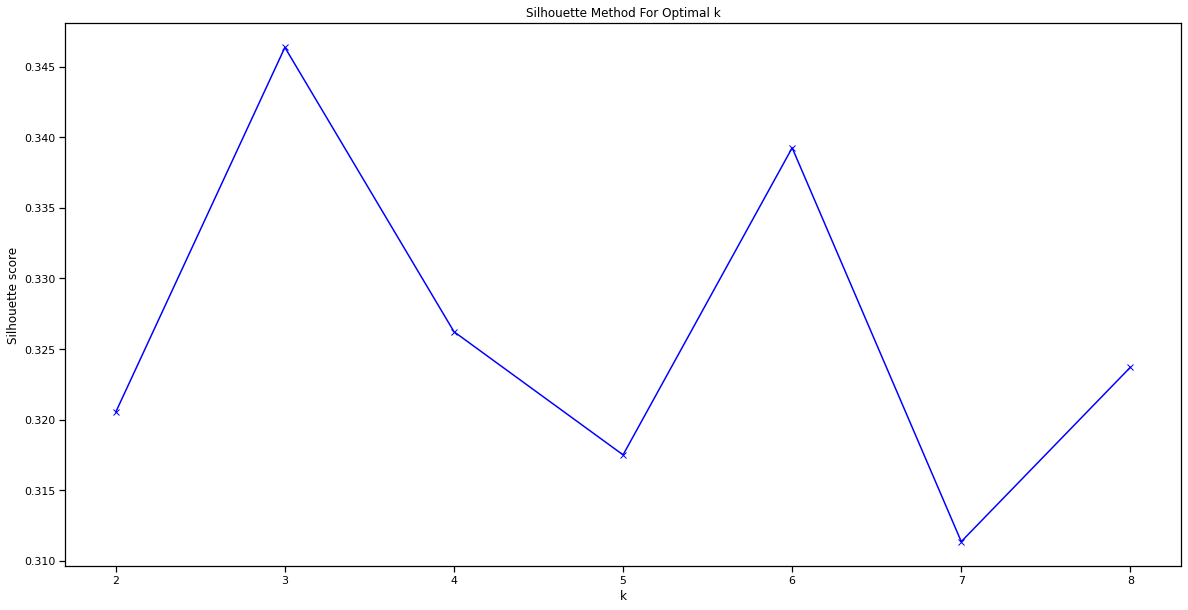

In [18]:
#Silhouette scoring to find the best number of clusters to utilise
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouettes = []
K = range(2, 9)
for c in tqdm(K):
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(U)
    agg_centroids = np.array([U[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
                            for k in range(c)])

    kmeans_clustering = KMeans(n_clusters=c, init = agg_centroids, n_init = 1)
    kmeans_ids = kmeans_clustering.fit_predict(U)
    score = silhouette_score(U, kmeans_ids)
    silhouettes.append(score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [19]:
#Clustering utilising optimal cluster number and centroids found with agglomerative clustering
k = 3
ids = AgglomerativeClustering(n_clusters=k).fit_predict(U)

centroids = np.array([U[ids == c].mean(axis=0) for c in range(k)])

km = KMeans(n_clusters=k, 
            n_jobs=-1,
           init = centroids, 
           n_init = 1)
km.fit(U)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


KMeans(init=array([[ -0.19029282, -13.083378  ],
       [-18.710596  ,  16.709267  ],
       [ 22.604874  ,  12.273449  ]], dtype=float32),
       n_clusters=3, n_init=1, n_jobs=-1)

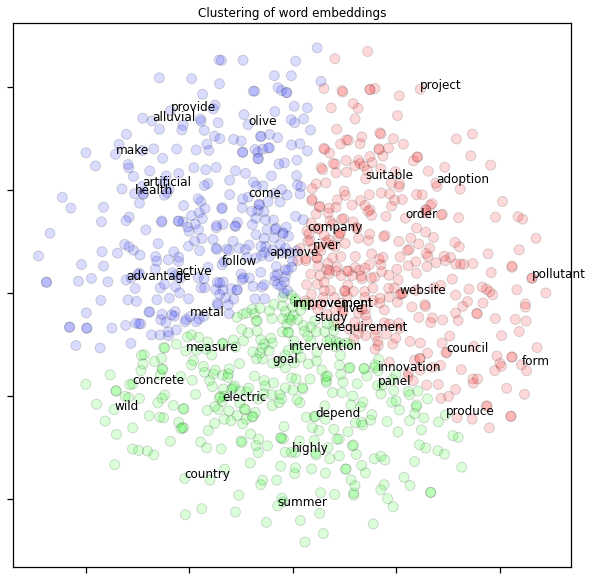

In [25]:
#Taking a sample of the data to make it easier to visualise
np.random.seed(4)
plot_vectors(U[0:1000], title = 'Clustering of word embeddings', labels=km.labels_[0:1000], dimensions = 2)

As it is possible to see from the clustering of the word embeddings above, there seem to be three dominant clusters (also pointed at by the silouhette score). However, upon closer inspection of words that belong to different clusters it is indeed quite difficult to point out at specific 'themes' or topics that might be inherent to that cluster's vocaboulary. Indeed, this analysis is not meant to replace the usage of a topic model, but rather it also helps to infrom the tuning of parameters for the later usage of a topic model. Infact, while providing a more generalised and rough look at the different contexts that might characterise what different documents talk about in the coprus, this analysis highlights how in general all words seem to have a very interrelated and similar context. This allows us to better understand the corpus, highlighting how there is a specific set of voucaboulary that generally characterises all projects in the field of environmental conservation (and thus it is useful to include such vocabulary if proposing a project to the EU LIFE program). At the same time it also allows us to set a prior to the distribution of words across different documents. Indeed, these results provide support to the fact that such distribution is likely to tend towards a unifrom (words are not very specific to particualr topics) and should be taken in to account in later analises.

## Sub-section 2: How do the projects that the EU funds differ across the world?
Note: This part of the analysis is done utilising the lemmatized words so as to reduce variablity from morphology and focus on only differences in the semantic meanings that would better allow to highlight underlying differences in topics across countries

### Author topic model

In [26]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from collections import defaultdict
from gensim.models import CoherenceModel
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import TruncatedSVD 
from sklearn import preprocessing
import numpy as np

In [27]:
#Modifying coprus structure to be usable for the athor topic model
instances = df.clean_lemma.tolist()
phrases = Phrases(instances, min_count=5, threshold=1 )
instances_colloc = phrases[instances]


dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below=50, no_above=0.3)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

In [29]:
#Creating mappings
author2doc = defaultdict(list)

for i, country in enumerate(df['cordinator_location']):
    author2doc[country].append(i)

In [30]:
#Tuning optimal topic number
coherence_values = []
author_model_list = []



for num_topics in tqdm(range(3, 20)):
    author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                    author2doc=author2doc,
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    passes = 10,
                                    alpha=0.5,
                                    eta = 0.85,
                                    random_state=42)
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    #print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

100%|██████████| 17/17 [26:35<00:00, 93.87s/it] 


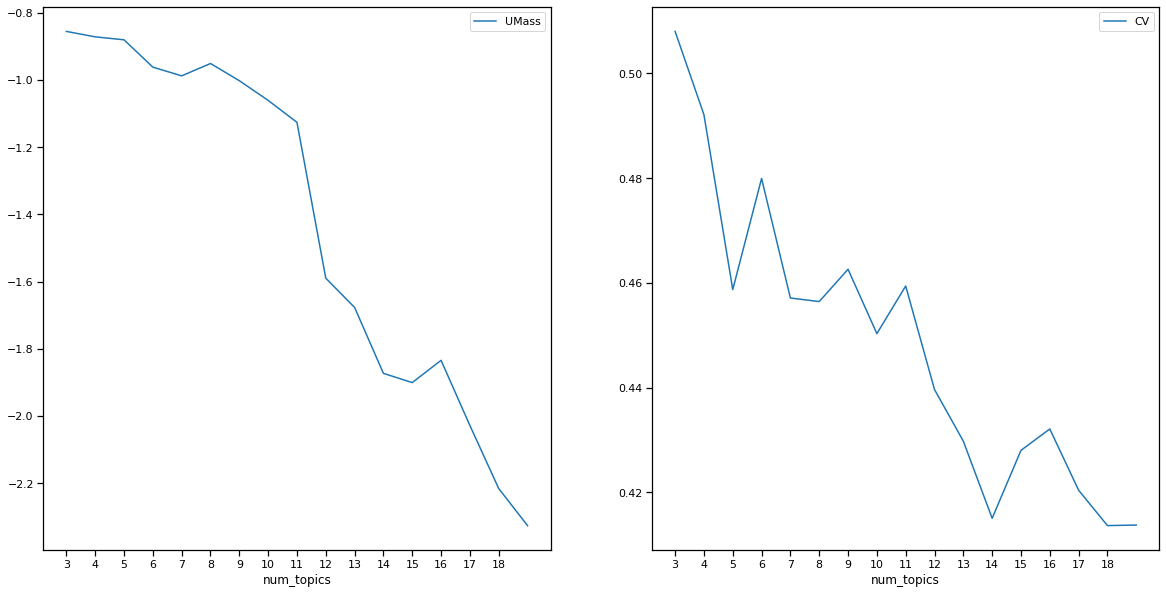

In [31]:
#Plotting scores
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,19));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,19));

As visible form the graphs above both coherence metrics point to an optimal number of topics of 3, which will thus be used in the tuned model below. Furthermore, specific choices for the **alpha** and **eta** parameters have been made. The **alpha** value has been chosen to be 0.5, so a midway between a 'peaky' and a uniform distribution of topics, due to the nature of the corpus. In fact, each document is a project descirptor that is takcling a specific environmental/sustainability issue in a specific part of the world, thus unlikely to talk about a wide range of topic equally. At the same time, as many environemntal issues are often interrelated and the oucomes of a project can have cascading effect on many fields (thus likely to be mentioned in a project's description) I have taken a more parsimonoius and balanced approach in tuning this parameter.

On the other hand, in making a choice for the **eta** value I considered the results of the word2vec clustering analysis present in sub-section 1. As we can see from the scatter graph the clsuters of the words, while being well defined, are increadibly close to one another, and often have many words mixing between clusters at border regions. This points at words having similar contexts and hence also hints at the fact that they are likely not super specific to one topic only. I have thus consequently set a higher **eta** value, closer to 1. 

Such choices seem to work well, producing well defined and coherent topics that are described below.

In [32]:
# Training the model with the best number of topics, both coherence metrics point to 3
n_topics_author = 3

author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=10,
                                alpha=0.5,
                                eta = 0.85, 
                                random_state=3)



In [33]:
# extract a list of tuples with topic number and descriptors from the model
author_model_topics = [(topic_no, re.sub("0\.[0-9]{3}\*", '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]


author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "waste", "environmental", "eu", "energy", "emission"
2 "conservation", "forest", "river", "natura", "restoration"
3 "conservation", "population", "local", "carry", "awareness"


Indeed as mentioned before topics seem to be coherent (although two share the same word but this is also likely related to the observation on **eta** and clustering made earlier).
Based on the decription words present above I will thus assign them the following topic labels:

Topic 1: **ENERGY MANAGEMENT**

Topic 2: **HABITAT PROTECTION**

Topic 3: **POPULATION AWARENESS**

In [34]:
# initialize mapping from covariate(=author/country) to topic distributions
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
# update mappings from model
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_countries = 'France Croatia Denmark'.split()      

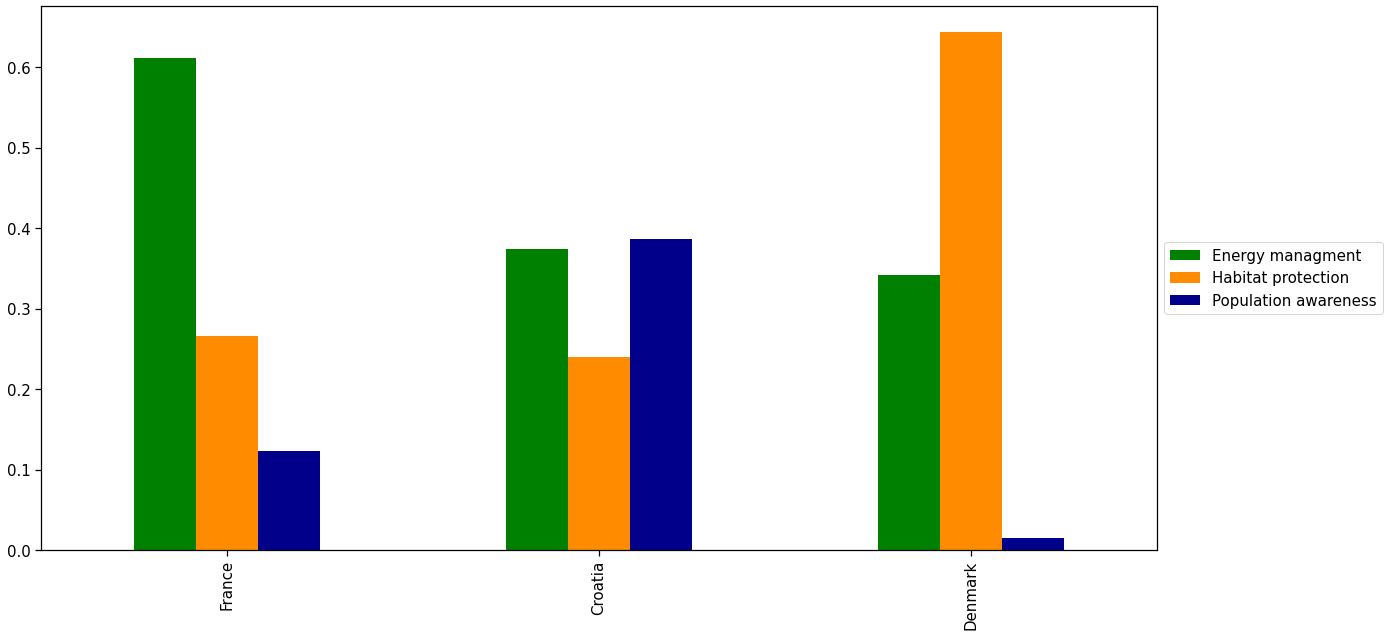

In [35]:
#Plotting topic distributions
author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax, color = ('green', 'darkorange', 'darkblue'))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels =['Energy managment', 'Habitat protection', 'Population awareness'], fontsize = 15 );

Through the author topic model analysis we can thus indeed understand the patterns of project fundings associated to each country. For example we can see that while in France we have a greater focus on Energy managment, in Denmark we instead have a lot more on Habitat protection. However, the EU LIFE project is active in 45 different countries around the world and, although through this method we can see that a certain country has projects focused more on one area compared to another, we have no way to clearly see how similar countries are to one another (and especially do so for all countries). Let's visualise this better:

### Doc2Vec Representation

In [36]:
#Creating TaggedDocument objects
corpus = []

for row in tqdm(df.iterrows()):
    label = row[1].cordinator_location
    text = row[1].clean_lemma
    corpus.append(TaggedDocument(words=text, 
                                 tags=[str(label)]))

# initializing model
d2v_model = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=0)

# building the vocabulary
d2v_model.build_vocab(corpus)

# training the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

5015it [00:00, 5523.54it/s]


### SVD

In [37]:
#Applying dimensionality reduction
#Here three latent dimensions are chosen so as to turn them in to RGB values
doc_embedding_array = d2v_model.dv.vectors
svd = TruncatedSVD(n_components=3)
U = svd.fit_transform(doc_embedding_array)
S = svd.singular_values_
V = svd.components_

In [38]:
#Scaling variable to be in 0-1 range for RGB conversion
scaler = preprocessing.MinMaxScaler()
scaled_RGB = scaler.fit_transform(U)

#Saving it as a DataFrame
list_RGB = scaled_RGB.tolist()
colors_c = pd.DataFrame({'country':d2v_model.dv.index_to_key, 'RGB': list_RGB})

In [39]:
#### Generating world map (REQUIRES GEOPANDAS PACKAGE and its dependencies) #####
import geopandas
##############################

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name !='Antarctica']

In [40]:
#Renaming some countries to comply with the names present in the geopandas library
for i in range(len(colors_c.country)):
    if colors_c.loc[i, 'country'] == 'Netherland':
        colors_c.loc[i, 'country'] = 'Netherlands'
    elif colors_c.loc[i, 'country'] == 'USA':
        colors_c.loc[i, 'country'] = 'United States of America'
    elif colors_c.loc[i, 'country'] == 'Tunisie':
        colors_c.loc[i, 'country'] = 'Tunisia'
    elif colors_c.loc[i, 'country'] == 'Bosnia_Herzegovina':
        colors_c.loc[i, 'country'] = 'Bosnia and Herz.'
    elif colors_c.loc[i, 'country'] == 'Czech Republic':
        colors_c.loc[i, 'country'] = 'Czechia' 
    elif colors_c.loc[i, 'country'] == 'Marocco':
        colors_c.loc[i, 'country'] = 'Morocco'

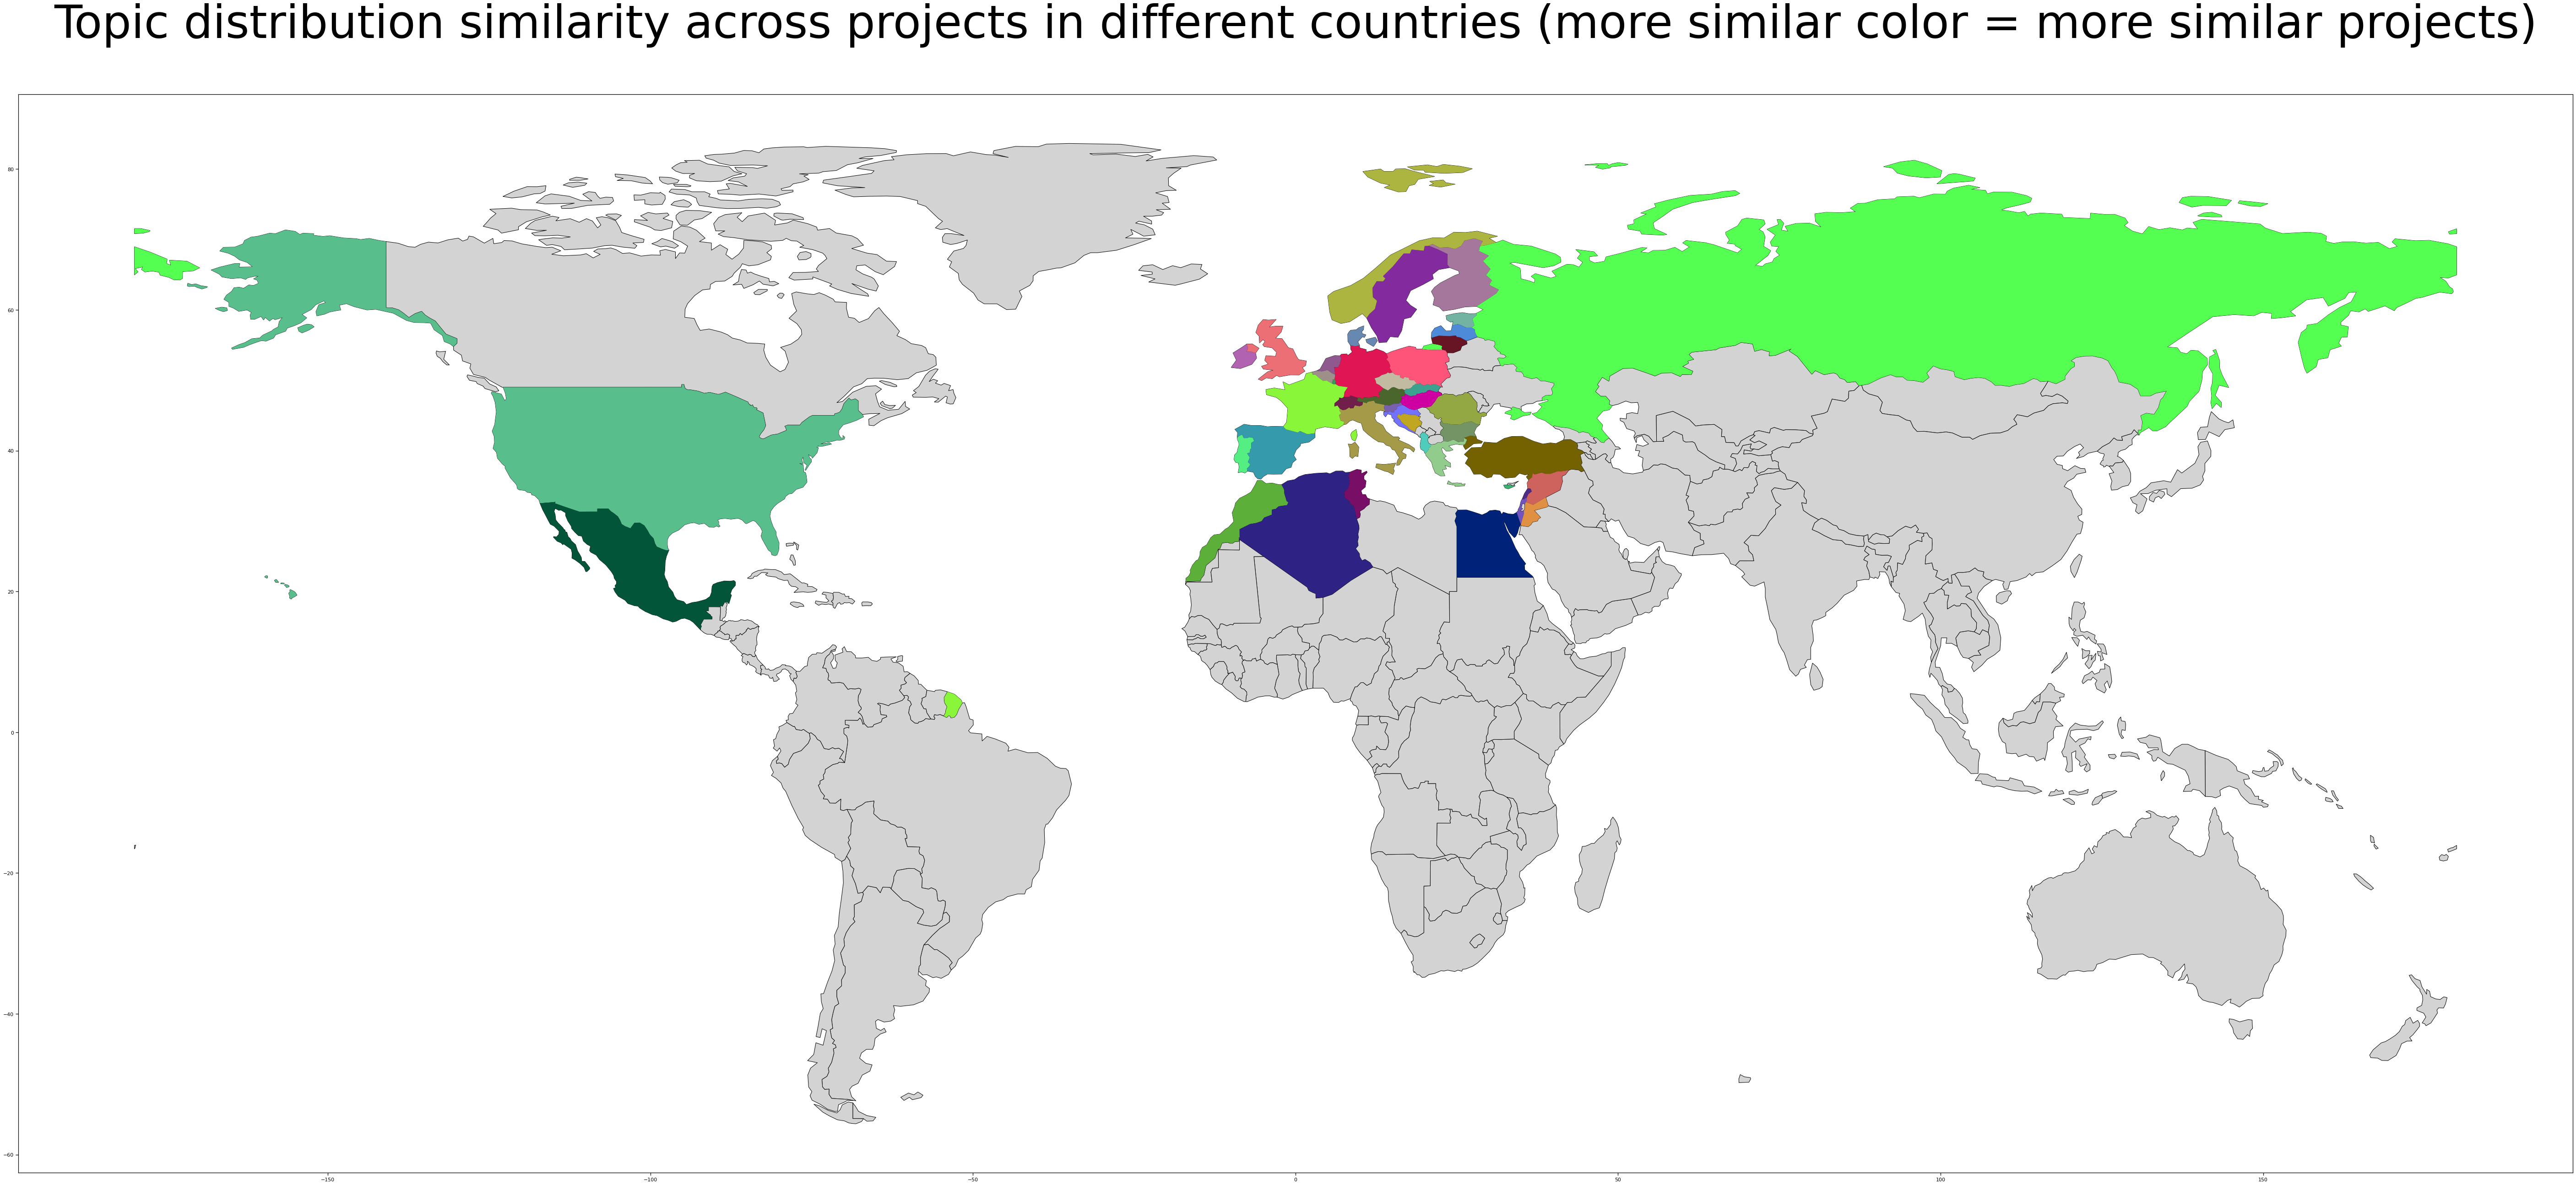

In [41]:
#Plotting the map with all countries colored by their vector
fig, ax = plt.subplots(figsize =(100,100))
world.plot(ax = ax, color = 'lightgrey', edgecolor = 'black',figsize = (100,100))
#fig.subplots_adjust(left=-20, bottom=-20, right=20, top=0, wspace=0, hspace=0)
for i in range(len(colors_c.country)):
    if colors_c['country'][i]!='Gaza_strip_West_Bank' and colors_c['country'][i]!='Malta':
        country = world[world.name ==colors_c['country'][i]]
        country.plot(ax = ax, color = colors_c['RGB'][i])
plt.title('Topic distribution similarity across projects in different countries (more similar color = more similar projects)', fontdict = {'fontsize':100}, y = 1.05)
plt.show()

Indeed, now we can better appreciate the areas in which the project funding is active, and the relationships that various countries have in term of similarity of focus on the different topics of the projects ran. As we can see the EU LIFE project seem to have greater activity in the Euro-mediterranean region, so let's zoom in our visualisation there to better explain the resulting interpretations.  

In [42]:
#Creating a list with the countries from where projects have been carried out
# plus some neighbouring countries to maintain the integrity of the plot
Euro_mediterranian = list(colors_c.country) + ['Sudan', 'Niger', 'Chad', 'Mali', 'W. Sahara','Mauritania', 'Iran', 'Iraq', 'Saudi Arabia','Libya', 'Ukraine', 'Belarus', 'Serbia','Georgia', 'Montenegro', 'Moldova', 'Kosovo', 'Macedonia']
EU = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
EU = EU.loc[(EU['name'].isin(tuple(Euro_mediterranian)))]
EU = EU[(EU.name !='United States of America') & (EU.name !='Mexico')]

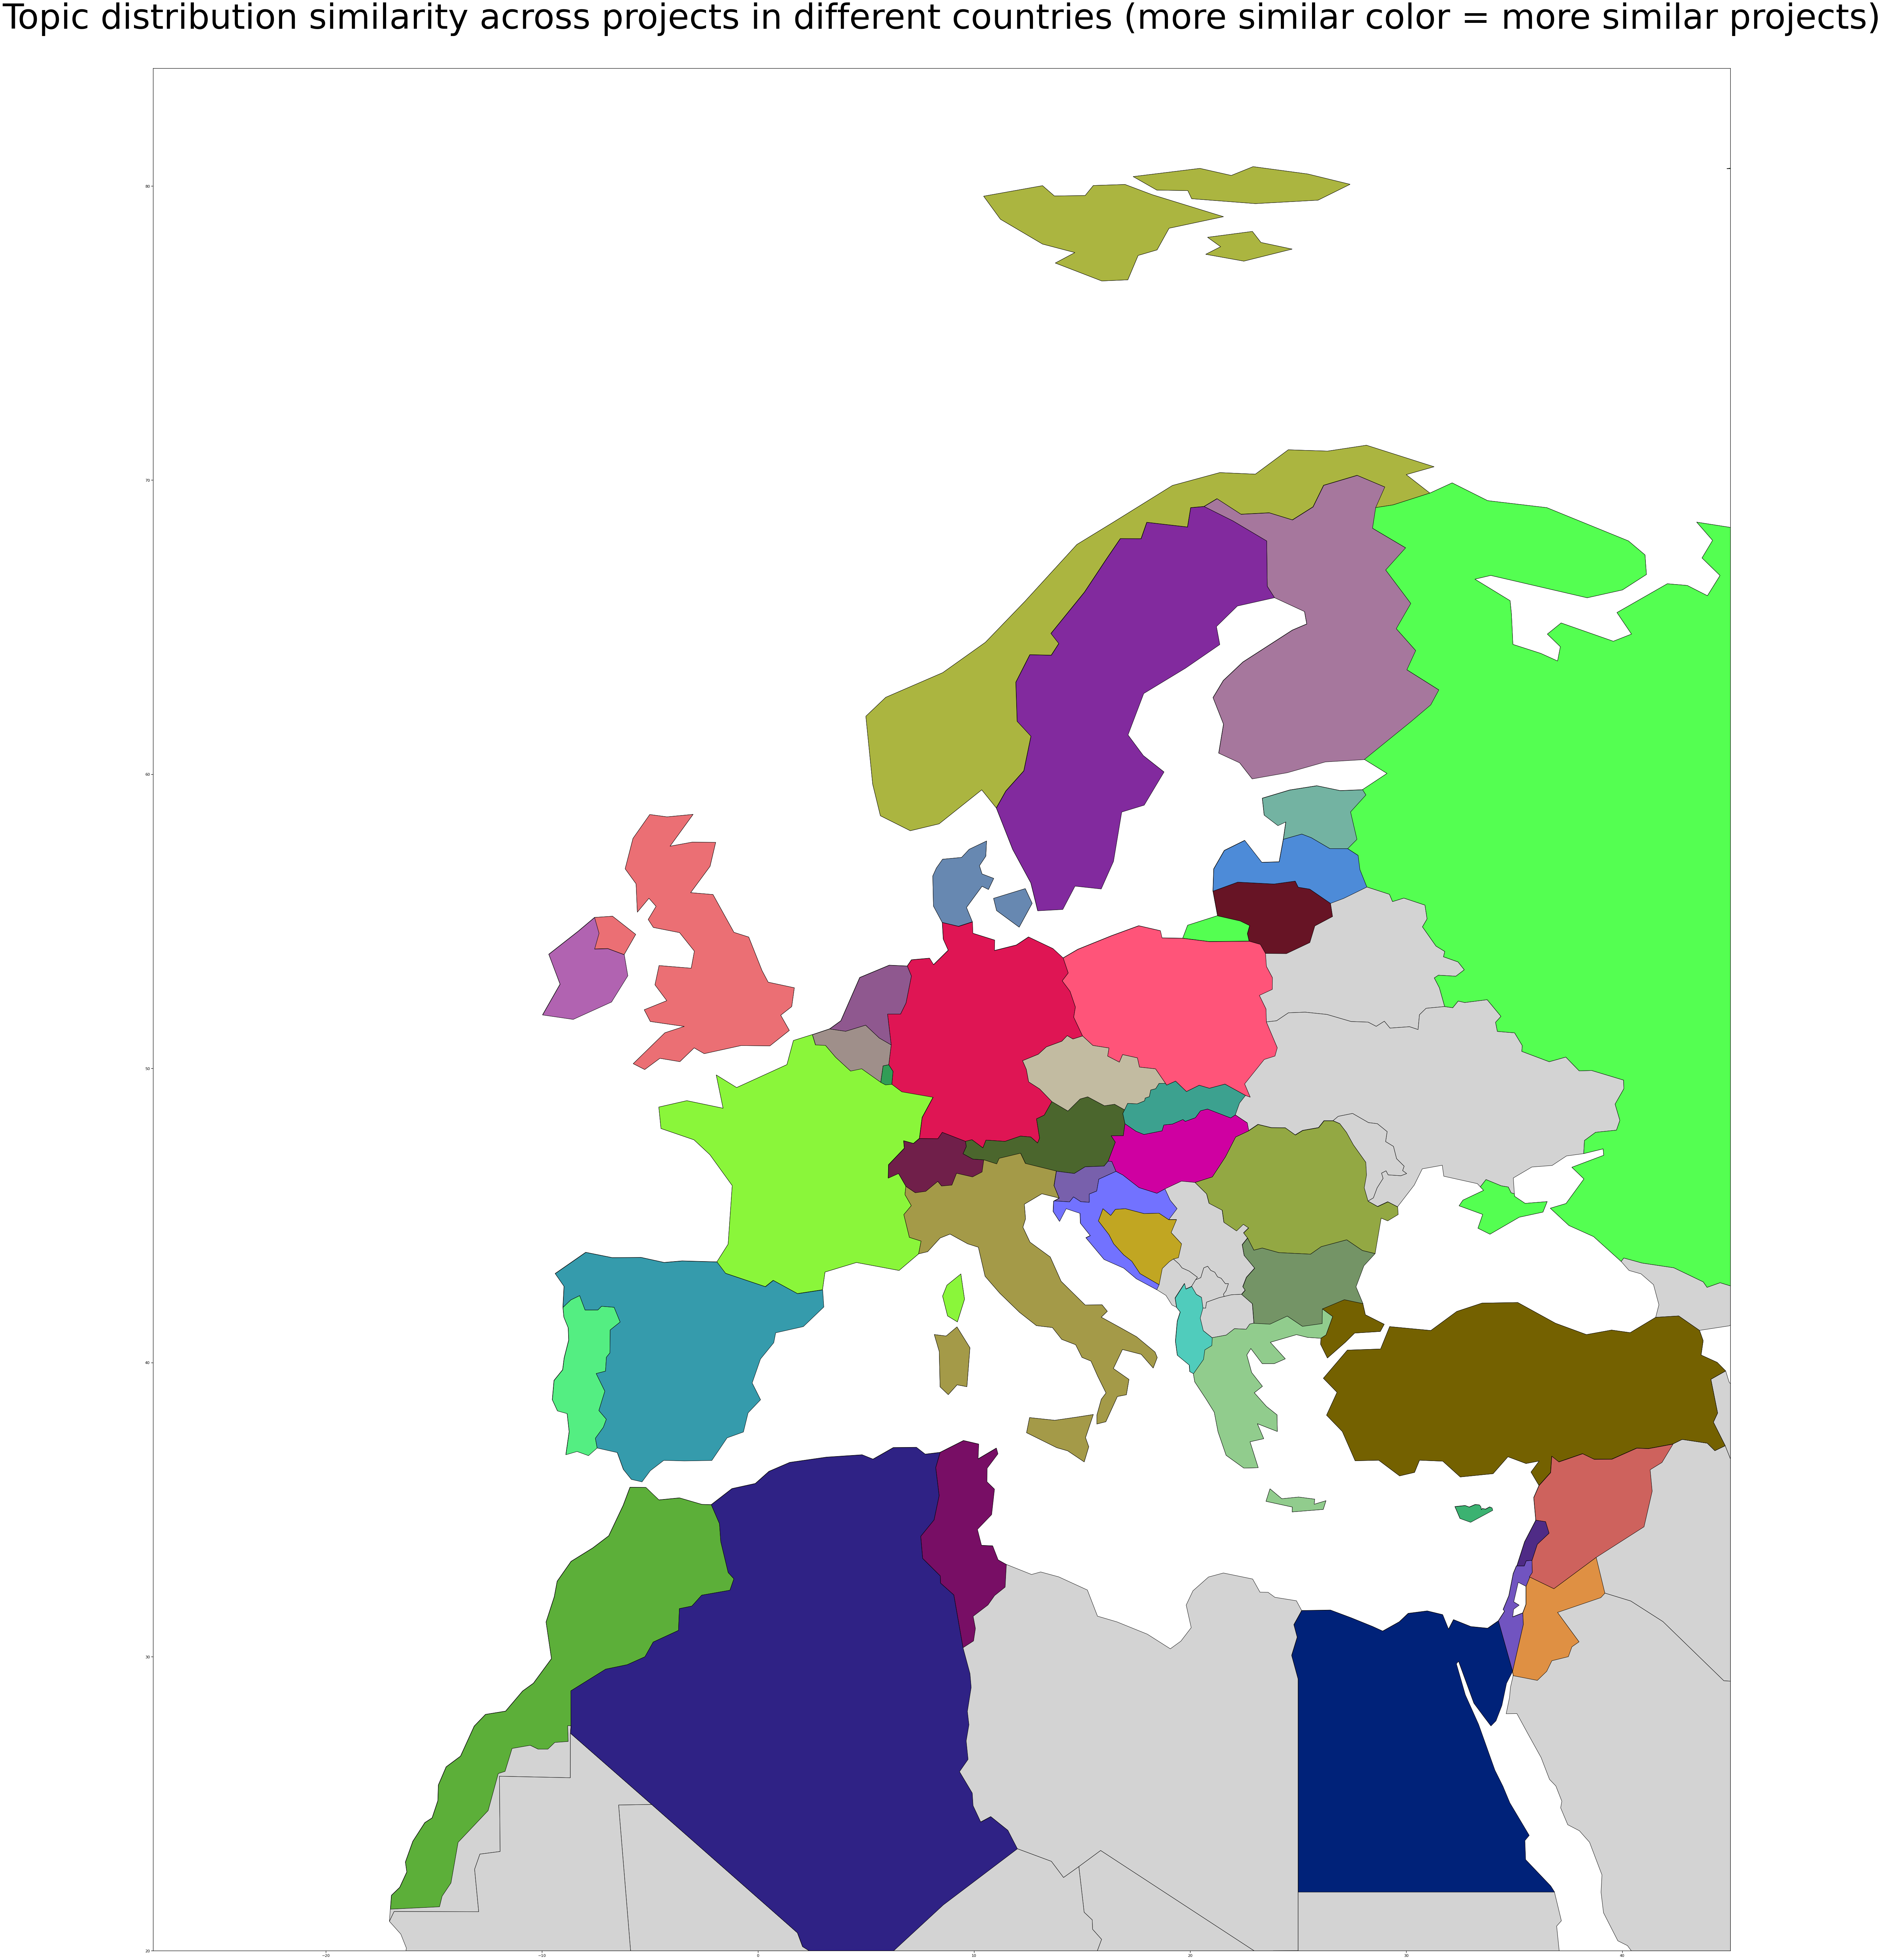

In [43]:
# Plotting the 'zoomed in' map on the euro-mediterranean section
fig, ax = plt.subplots(figsize =(100,100))
EU.plot(ax = ax, color = 'lightgrey', edgecolor = 'black',figsize=(20, 50))
for i in range(len(colors_c.country)):
    if colors_c['country'][i]!='Malta' and colors_c['country'][i]!='Mexico' and colors_c['country'][i]!='United States of America' and colors_c['country'][i]!='Gaza_strip_West_Bank' :
        country = EU[EU.name ==colors_c['country'][i]]
        #name = EU[EU.name ==colors_c['country'][i]].iloc[0, 2]
        #lat = coordinates[coordinates.CountryName == name].iloc[0,2]
        #long = coordinates[coordinates.CountryName == name].iloc[0,3]
        country.plot(ax = ax, color = colors_c['RGB'][i], edgecolor = 'black')
ax.set_xlim(-28, 45)
ax.set_ylim(20, 84)
plt.title('Topic distribution similarity across projects in different countries (more similar color = more similar projects)', fontdict = {'fontsize':100}, y = 1.02)
plt.show()

As it's possible to see, now we can better highlight some trends of similarities amongst countries that the topic model barcharts alone would have not highlighted. It seems that for example Germany, Poland and the UK are more similar in the overall topics distribution of the projects ran, while being quite different from projects ran by Egypt and Algeria who are on a different end of the RGB scale. Indeed, since we have only three topics, we can combine the insights from this visualisation and the barcharts to understand what being closer to green, blue or red means. As we can see from the graph below (taking countries at the extreme of the RGB scale such as UK, France and Algeria) we can see that blue seems to be more related to topic distributions higher in population awareness, while closer to green is Energy Managment and red is Habitat Protection.

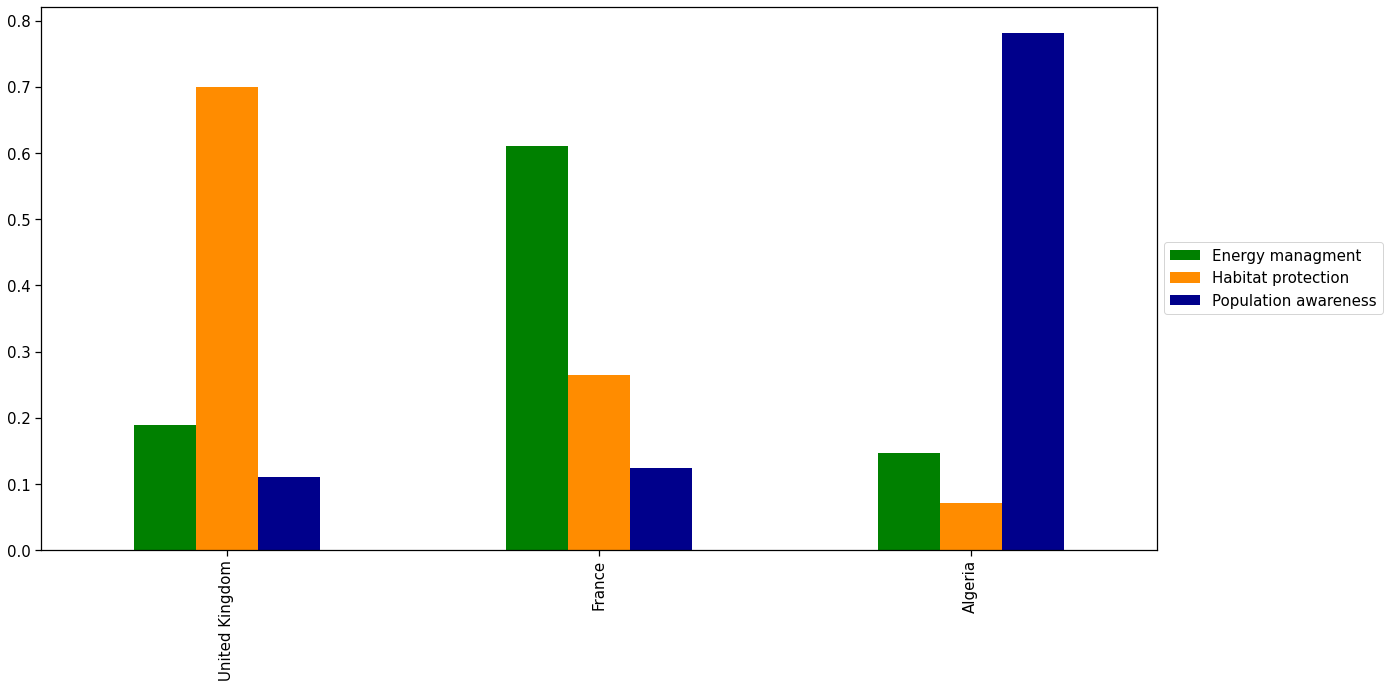

In [44]:
#Plotting topic distributions
target_countries = 'United Kingdom,France,Algeria'.split(',')   

author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax, color = ('green', 'darkorange', 'darkblue'))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels =['Energy managment', 'Habitat protection', 'Population awareness'], fontsize = 15 );

## Sub-section 3: How do EU project-funding patterns change across time ?
Note: This analysis utilises the NON-lemmitised preprocessed corpus. In fact, as we are comparing documents over different time periods the morphological and syntactical information that is encoded in the words is important. Indeed, different time periods might favour different morphological forms of the same words, thus including this information might help understand difference connotations in the usage of some terminology and better inform the models.

## Topic Model

The following analysis aims at understanding the patterns of funding of the EU LIFE program across the 29 years in which it has been operational. It allows to gain insights in to how the pattern of funding for projects related to different topics might have changed throughout this period.

Unlike in the previous section, instead of utilising an Author Topic model to learn distribiton for each year while training, I have opted instead for the usage of a standard Topic Model. 

This methodology, allows me to ultimately get a distribution of topics for each individual document, thus enabling me to combine insights gathered from the model with other data present in my dataset and better answer the question above.
Although I am aware that this method will tend to over estimate the topic distribution of non-dominant topics,the method is still robust in highlighting which topic is actually domninant, thus still enabling me to succesfully carry out the analysis planned and uncover potential trends.

In [36]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
import matplotlib.pyplot as plt
import seaborn

In [37]:
instances2 = df.clean_text.tolist()
phrases2 = Phrases(instances2, min_count=5, threshold=1 )
instances_colloc2 = phrases2[instances2]


dictionary2 = Dictionary(instances_colloc2)

dictionary2.filter_extremes(no_below=30, no_above=0.4)
ldacorpus2 = [dictionary2.doc2bow(text) for text in instances2]
tfidfmodel = TfidfModel(ldacorpus2)
model_corpus = tfidfmodel[ldacorpus2]

In [38]:
coherence_values2 = []


for num_topics in tqdm(range(2, 16)):
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary2, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances2, 
                                          dictionary=dictionary2, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances2, 
                                       dictionary=dictionary2, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    coherence_values2.append((num_topics, umass_score, cv_score))

100%|██████████| 14/14 [10:44<00:00, 46.01s/it]


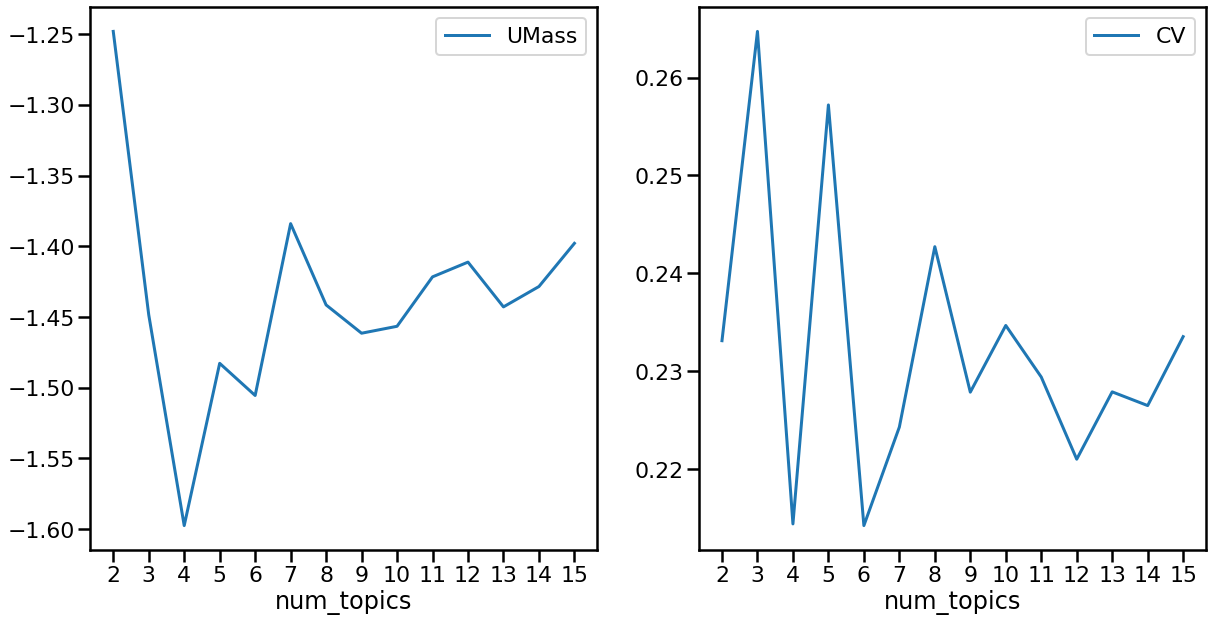

In [40]:
%matplotlib inline

seaborn.set_context('poster') # use large font


scores = pd.DataFrame(coherence_values2, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,16));



Indeed also in this context it seems like the best number of topics is 3 and, being connsistent with the same reasoning as last time for **alpha** and **eta**, we train the topic model with the specified set of parameters.

In [41]:
model = LdaMulticore(num_topics=3,
                     corpus=model_corpus, 
                     id2word=dictionary2,
                     passes=10, 
                     chunksize=len(model_corpus)*0.05,
                     alpha=0.5,
                     eta = 0.85,
                     random_state=5
                    )
    

In [42]:
topic_corpus = model[model_corpus]

In [43]:
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub("0\.[0-9]{3}\*", '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "species", "habitats", "conservation", "forest", "habitat"
2 "climate", "adaptation", "change", "urban", "policy"
3 "waste", "energy", "water", "emissions", "treatment"


As its possible to see the model generates coherent topics also in this scenario. Indeed, while two of the topic essentially remain similar a topic that seems to have to do with climate change is introduced. The topic labels that I will assign to the above topics are:

Topic 1: **HABITAT PROTECTION**

Topic 2: **CLIMATE CHANGE**

Topic 3: **ENERGY MANAGEMENT**

In [44]:
target_category = 'start_year'

# list with the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(topic_corpus))]

# turning it into a data frame
topic_distros = pd.DataFrame(data=scores, columns=descriptors)

# add the review category of each document as column (so we can aggregate)
topic_distros['category'] = df[target_category]

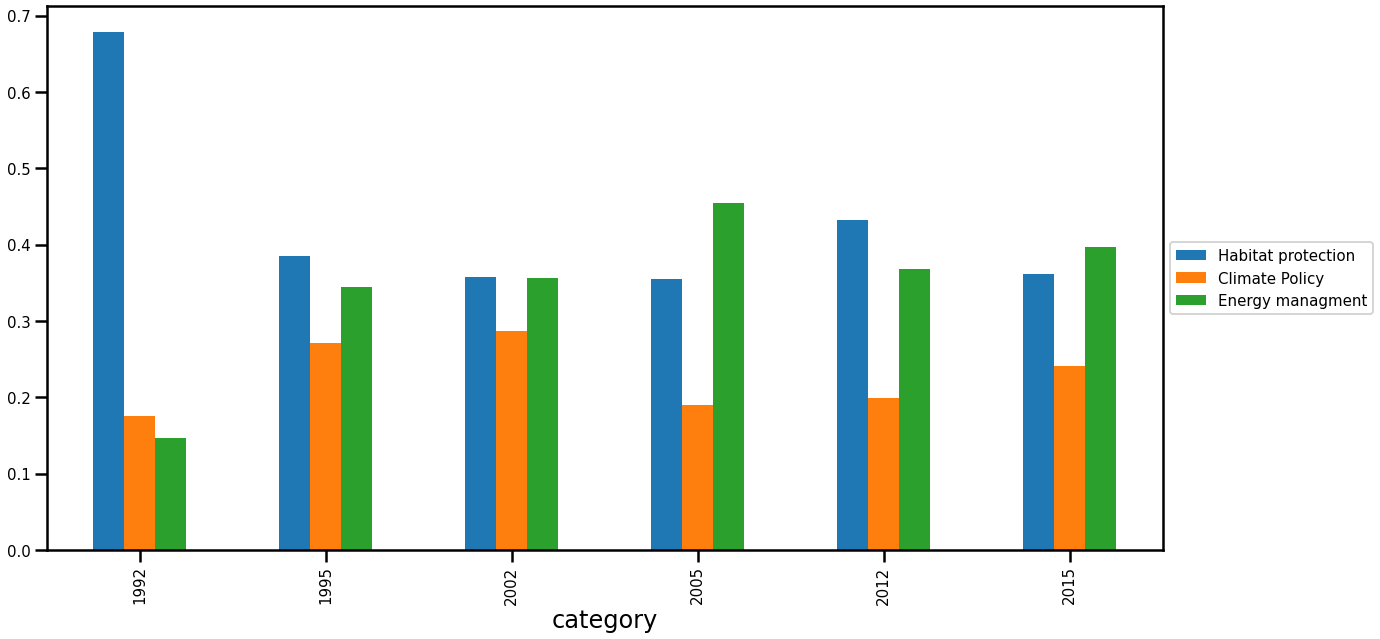

In [45]:
seaborn.set_context('poster') # use large font
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size

# aggregate topics by categories
#Selecting just a few subcategories(just some countries)
aggregate_by_category = topic_distros[topic_distros.category.isin([1992, 1995, 2002, 2005, 2012, 2015])]

#aggregating by country and returning the mean dist score for each topic for each country
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);

# move the legend out
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labels =['Habitat protection','Climate Policy',  'Energy managment'], fontsize = 15 );

## Insights

Now that we have distributions for the topics in each document we can use this to understand the patterns of funding given to the macro topic areas throughout the years. Indeed, by assigning to each project the label of the topic that is most dominant in the distribution, and combining this new label with the data on the amount of euros granted by the EU for that project, we can better quantify and visualise differences in the amount invested in each topic area.

In [46]:
# Assigning the 'dominant topic' to each project
dominant_topic = []
for i in range(len(topic_distros)):
    d = topic_distros.iloc[i, 0]
    t = 'Climate policy'
    if topic_distros.iloc[i, 1]>d:
        t = 'Habitat protection'
    elif topic_distros.iloc[i, 2]>d:
        t = 'Energy management'
    dominant_topic.append(t)
df['topic'] = dominant_topic
grouped = df.groupby(['start_year', 'topic']).sum(['budget_€', 'EU_contribution_€'])

In [47]:
#Aggregating by year and topic to get an average percentage of contribution 
#by the EU for each topic in each year

grouped = df.groupby(['start_year', 'topic']).sum(['budget_€', 'EU_contribution_€'])
aggreg = grouped.reset_index(level = 0)
aggreg.reset_index(level = 0, inplace = True)
aggreg['percent'] = round(aggreg['EU_contribution_€']/aggreg['budget_€']*100, 1)
aggreg.head(6)

,topic,start_year,end_year,budget_€,EU_contribution_€,percent
0,Climate policy,1992,131835,95082404,50226453,52.8
1,Energy management,1992,3991,10060348,2221063,22.1
2,Habitat protection,1992,25941,18515661,8265643,44.6
3,Climate policy,1993,101809,123120092,35600978,28.9
4,Energy management,1993,35928,25617602,7491863,29.2
5,Habitat protection,1993,79825,53925230,19473104,36.1


In [48]:
#Appending a row of values for 2007 where there were no projects on energy managment following our assumptions on topics
y2007 = pd.DataFrame({'topic': 'Energy management', 'start_year':2007, 'end_year':0,'budget_€': 0, 'EU_contribution_€':0, 'percent':0 }, index = [0])
aggreg = pd.concat([aggreg.iloc[:46], y2007, aggreg.iloc[46:]]).reset_index(drop = True)

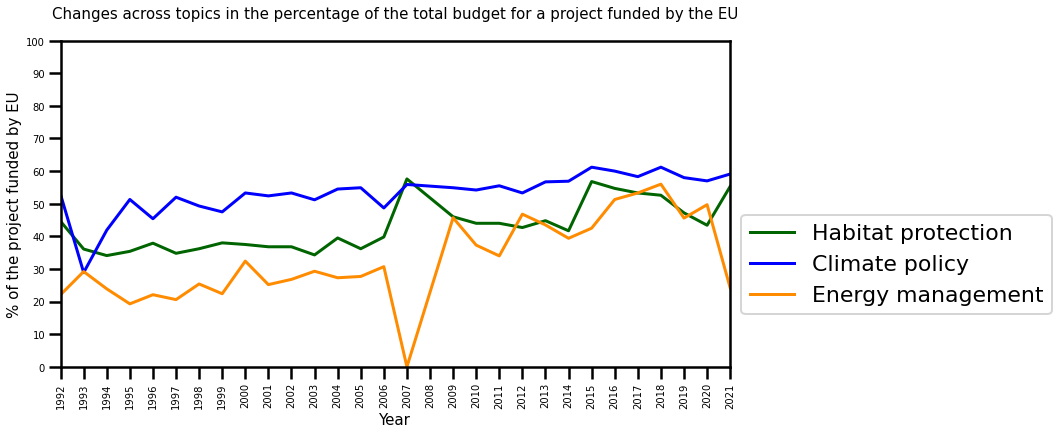

In [49]:
#Plotting
%matplotlib inline

years = list(set(aggreg.start_year))
t1 = list(aggreg[aggreg['topic']=='Habitat protection']['percent'])
t2 = list(aggreg[aggreg['topic']=='Climate policy']['percent'])
t3 = list(aggreg[aggreg['topic']=='Energy management']['percent'])

x = []
y = []
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(years, t1, label = 'Habitat protection', color = 'darkgreen')
ax.plot(years, t2, label = 'Climate policy', color = 'blue')
ax.plot(years, t3, label = 'Energy management', color = 'darkorange')
ax.legend(bbox_to_anchor=(1.0, 0.5))

plt.xlim([1992, 2021])
plt.ylim([0,100])

plt.xticks(range(1992,2022),rotation = 90, fontsize = 10)
plt.yticks(range(0,110, 10),['0', '10','20', '30', '40', '50', '60', '70', '80', '90', '100'], fontsize = 10)
plt.title('Changes across topics in the percentage of the total budget for a project funded by the EU', fontdict = {'fontsize':15}, y= 1.05)
plt.xlabel('Year', fontdict = {'fontsize':15})
plt.ylabel('% of the project funded by EU', fontdict = {'fontsize':15})
plt.show()

In [50]:
# Calculating the percentge of money invested by the EU in each topic over the total invested for each year
t1p = []
t2p = []
t3p = []

for i in years:
    tot = aggreg[aggreg['start_year'] == i]['EU_contribution_€'].sum()
    l = list(aggreg[aggreg['start_year'] == i]['EU_contribution_€']/tot*100)
    t1p.append(round(l[0], 1))
    t2p.append(round(l[1], 1))
    t3p.append(round(l[2], 1))


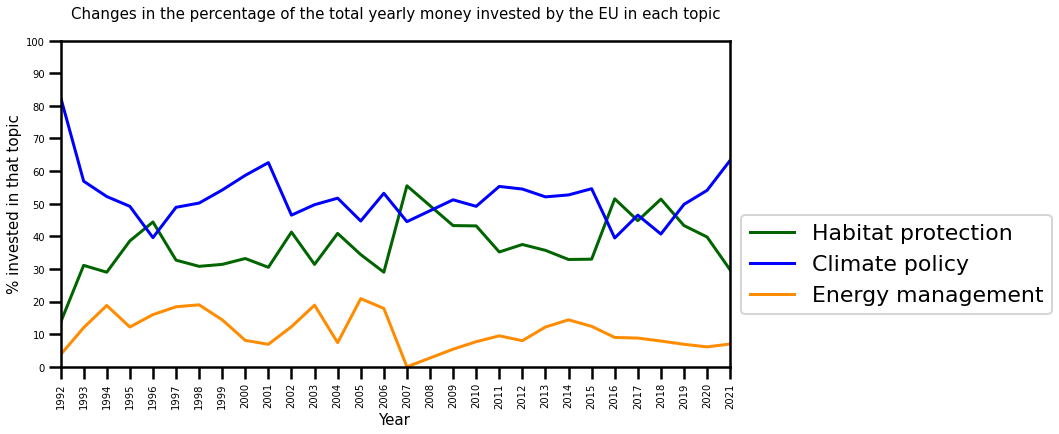

In [51]:
#Plotting
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(years, t3p, label = 'Habitat protection', color = 'darkgreen')
ax.plot(years, t1p, label = 'Climate policy', color = 'blue')
ax.plot(years, t2p, label = 'Energy management', color = 'darkorange')

ax.legend(bbox_to_anchor=(1.0, 0.5))


plt.xlim([1992, 2021])
plt.ylim([0,100])

plt.xticks(range(1992,2022),rotation = 90, fontsize = 10)
plt.yticks(range(0,110, 10),['0', '10','20', '30', '40', '50', '60', '70', '80', '90', '100'], fontsize = 10)
plt.title('Changes in the percentage of the total yearly money invested by the EU in each topic', fontdict = {'fontsize':15}, y = 1.05)
plt.xlabel('Year', fontdict = {'fontsize':15})
plt.ylabel('% invested in that topic', fontdict = {'fontsize':15})
plt.show()

The information from the topic models joint with financial data thus highlights interesting trends in the patterns of funding of the EU in projects of various topics. Indeed, from the first plot it seems that overall the EU is generally increasing the proportion of the project it funds in all areas related to sustainability (thus actually paralleling the socio political trend that we have been seeing for the past couple of decades). 

It does seem that projects that have a higher percentage of their budget funded by the EU are those related to climate change. It is interesting to note that the increasing trend for this topic seems to become 'less wiggly' and more marked around 1997. This is infact the year where many EU countries signed the Kyoto agreement to reduce emissions to fight global warming. Indeed, the analysis suggests that the protocol might have had an important impact on the increase in committment that the EU decided to put on projects combating climate change.

From the second plot instead we can notice that out of all of the money utilised in any given year to fund projects, Energy managments are those that proportionally to the other two receive less of these funds. It might be likely that many of the projects that also include the topic of energy management might be interrelated with climate change projects, indeed pointing at a potential limitation of this analysis. Neverthless, considering the recent political situation and the struggle that the EU is facing in effectively securing stable sources of energy, the data does still point at an interesting insight. Indeed, it will be interesting to track the evolution of these trends further and see how they evolve in the next decade.

## Sub-section 4: Using previous projects to inform new ones
In this section I try and utilise previous titles of projects ran by the EU LIFE program to generate new
titles for new synthetic projects. This is doen thought the use of a Language model that is optimised to have
the lowest perplexity on the existing corpus

## Language Model

In [1]:
from collections import defaultdict
import numpy as np
import nltk

def best_lm_title(country): 
    '''
    In order the function executes:
    1. restricts corpus based on user's choosen country
    2. Iteratively fits Language Models for a range of smoothing values on the restricted corpus
    3. Calculates the perplexity of each model on the first docuemnt of the corpus
    4. chooses the smoothing value that results in lowest perplexity and generates a synthetic document based
    on a model trained with the optimal smoothing value
    
    '''
    corp = df[df['cordinator_location'] == country].project_title.tolist()
    perple = []
    l = [i/1000 for i in range(1, 11)]
    
    #Generating language models
    for i in l:
        smoothing = i
        START = '_***_'
        STOP = '_STOP_'

        counts = defaultdict(lambda: defaultdict(lambda: smoothing))

        corpus = [i.strip().split() for i in corp]

        for sentence in corpus:
            tokens = [START, START] + sentence + [STOP]
            for u, v, w in nltk.ngrams(tokens, 3):
                counts[(u, v)][w] += 1
        
        def logP(u, v, w):
            """
            compute the log probability of a trigram
            (u,v,w) => P(w|u,v) = c(u,v,w) / SUM(c(u,v,*))
            """
            return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

        def sentence_logP(S):
            """
            score a sentence in log likelihood with chain rule
            S: list(str)
            """
            tokens = [START, START] + S + [STOP]
            return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])

        def get_perplexity(corpus):
            """
            perplexity = 2^entropy(X)
            entropy = -sum(p(x) *log(p(x)))
            """
            from math import exp
            START = '_***_'
            STOP = '_STOP_'
            tot_perplexity= 0
            for s in corpus:
                tokens = [START, START] + s + [STOP]
                ts = sum([exp(logP(u,v,w))*logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])
                tot_perplexity += ts

            return 2**(-tot_perplexity)


        

        #calculating perplexity of the model on an actual title of a project form the country
        perple.append(get_perplexity([i.split() for i in [corp[0]]]))
    
    #finding smoothing value with lowest perplexity
    best_smooth = l[min(enumerate(perple))[0]]
    
    #fitting new model with best smoothing
    smoothing = i
    START = '_***_'
    STOP = '_STOP_'

    counts = defaultdict(lambda: defaultdict(lambda: smoothing))

    corpus = [i.strip().split() for i in corp]

    for sentence in corpus:
        tokens = [START, START] + sentence + [STOP]
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[(u, v)][w] += 1

    
    def generate():
        """
        generate a new sentence
        """
        result = [START, START]

        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)

        while next_word != STOP:
            next_word = sample_next_word(result[-2], result[-1])
            result.append(next_word)

        return ' '.join(result[2:-1])

    def sample_next_word(u, v):
        """
        sample a word w based on the history (u, v)
        """
        keys, values = zip(*counts[(u, v)].items())

        values = np.array(values)
        values /= values.sum() 

        sample = np.random.multinomial(1, values)

        return keys[np.argmax(sample)]

    return print(generate())

### Generating Titles
By running the next cell the user is prompted to input the country for which they would like to generate a project proposal and after a short computation they receive a potential project title. The user is asked to choose from a list of 'suported countries' as these are those countries for which there are a larger amount of 
projects in the dataset, allowing to generate a more consistent conditional word distribution for the Language model to work effectively.

In [3]:
print('''Welcome to the project generation portal!
This project is intended as a source of inspiration for researchers in the field of 
habitat conservation, climate research and energy. 
It offers titles for potential new projects that can be investigated in a EU country of choice. All titles are artificially fabricated through a Language Model so there is no guarantee of the fisibility of the actual
project. However, there is nothing stopping interested users from looking deeper in the actual practicality of such titles. So far supported countries are:
    1. Italy
    2. Spain
    3. Germany
    4. United Kingdom
    5. France''')

Welcome to the project generation portal!
This project is intended as a source of inspiration for researchers in the field of 
habitat conservation, climate research and energy. 
It offers titles for potential new projects that can be investigated in a EU country of choice. All titles are artificially fabricated through a Language Model so there is no guarantee of the fisibility of the actual
project. However, there is nothing stopping interested users from looking deeper in the actual practicality of such titles. So far supported countries are:
    1. Italy
    2. Spain
    3. Germany
    4. United Kingdom
    5. France


In [5]:
country = input('''Country where you would like to run new project: ''')
print('Generating...')
print(' ')
print('Proposed project:')
best_lm_title(country)


Country where you would like to run new project: Germany
Generating...
 
Proposed project:
Non-emmission demonstration plant for non-polluting drying of wet grassland breeding bird habitats in Brandenburg


## Conclusion

In conclusion, through the usage of NLP techniques it has been possible to analyse the work that the EU LIFE program has done in its 29 years of activity thus far. 

In particular, it has been possible to understand the specificity that such projects have when it comes to their vocaboulary, with words generally being quite close to one another's context and thus associated to the majority of the topics that are addressed. Indeed, such results not only were helpful in informing the subsequent tuning of other algorithms' parameters, but also can help inform potential researchers on the importance of the use of the right terminology when compiling such project descirptions.

In addition, a second analysis allowed to uncover the topics that were present in the corpus of different projects In particular, it also highlighted patterns of similarities in the distribution of such topics across the various countries that take part in the EU LIFE program, signifying how some countries have projects more focused on topics like Habitat Protection (ex. Germany, UK), while others on Population awareness (ex.Egypt, Algeria). 

Furthermore, a third analysis revealed that the amount that the EU has invested in projects of different topics has indeed changed thoughout the time this programm has been active. In particular it was possible to see actionable responses the EU took to historical events, helping to explain some of the funding patters seen.

Finally, a last section provided a useful tool to stimulate curiosity and further research in the fields of climate, energy and conservation.